In [20]:
import os
import warnings
from time import time

import numpy as np
import matplotlib.pyplot as plt

import pyart

import leroi

warnings.filterwarnings("ignore")

/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#configure gridding
gs = (40, 301, 301) #grid steps (z,y,x)
gb = ((500, 20000), (-150000,150000),(-150000,150000)) #grid range (z,y,x)
center_pos = (0,0,0) #radar position on Cartesian grid

x = np.linspace(gb[2][0],gb[2][1], gs[2])
y = np.linspace(gb[1][0],gb[1][1], gs[1])
z = np.linspace(gb[0][0],gb[0][1], gs[0])
coords = (z-center_pos[0], y-center_pos[1], x-center_pos[2])


In [32]:
def _load_radar(radar_ffn, dbz_fname, grid_fields):
    #read radar data
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        radar = pyart.io.read(radar_ffn)
    #add height field
    radar.add_field_like(dbz_fname, 'height', radar.gate_altitude['data'])
    #mask invalid
    radar = leroi.mask_invalid_data(radar, dbz_fname, add_to = grid_fields, min_field = 0, min_area = 50, return_smooth = False)
    return radar

def run_leroi_grid(radar_ffn, dbz_fname='DBZH', grid_fields=['DBZH','VRADH'], Rc=3500, k=200):
    #load data
    radar = _load_radar(radar_ffn, dbz_fname, grid_fields)
    
    #run gridding
    fields = leroi.cressman_ppi_interp(radar, coords, grid_fields, Rc=Rc, k=k, verbose=False)
    grid = leroi.build_pyart_grid(radar, fields, gs, gb)
    
    return grid
    
        
def run_const_cressman(odimh5_ffn, dbz_fname, grid_fields, roi=3500):
    #load data
    radar = _load_radar(odimh5_ffn, dbz_fname, grid_fields)
    #init latlon
    lon0, lat0 = radar.longitude['data'][0], radar.latitude['data'][0]
    #run gridding
    gatefilter = pyart.correct.GateFilter(radar)
    gatefilter.exclude_masked(dbz_fname, exclude_masked=True)
    grid = pyart.map.grid_from_radars(radar, grid_origin = (lat0, lon0), grid_shape=gs, roi_func = 'constant', constant_roi = roi,
                                      weighting_function = 'Cressman', grid_limits=gb, fields=grid_fields, gatefilter=gatefilter)
    return grid

def run_test(odim_ffn, dbz_fname, vrad_name, grid_fields, level=5, yidx=145, k=200):
    
    #grid
    start = time()
    leroi_grid = run_leroi_grid(odim_ffn, dbz_fname=dbz_fname, grid_fields=grid_fields, k=k)
    end = time()
    leroi_time = end-start
    
    start = time()
    pyart_grid = run_const_cressman(odim_ffn, dbz_fname=dbz_fname, grid_fields=grid_fields)
    end = time()
    pyart_time = end-start
    
    #plot horizontal cross section
    fig = plt.figure(figsize=[14,14])
    leroi_display = pyart.graph.GridMapDisplay(leroi_grid)
    pyart_display = pyart.graph.GridMapDisplay(pyart_grid)
    
    ax = plt.subplot(221)
    ax.set_title(f'leroi reflectivity grid. Runtime:{leroi_time:.2f}s')
    img = plt.pcolormesh(y,x,leroi_grid.fields[dbz_fname]['data'][level,:,:], vmin=0, vmax=60, cmap='pyart_HomeyerRainbow')
    plt.plot([-150000,150000],[-150000+yidx*1000,-150000+yidx*1000],'k-')
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label('dBZ')
    plt.grid()
    
    ax = plt.subplot(222)
    ax.set_title(f'pyart reflectivity grid. Runtime:{pyart_time:.2f}s')
    img = plt.pcolormesh(y,x,pyart_grid.fields[dbz_fname]['data'][level,:,:], vmin=0, vmax=60, cmap='pyart_HomeyerRainbow')
    plt.plot([-150000,150000],[-150000+yidx*1000,-150000+yidx*1000],'k-')
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label('dBZ')
    plt.grid()
    
    ax = plt.subplot(223)
    ax.set_title(f'leroi velocity grid. Runtime:{leroi_time:.2f}s')
    img = plt.pcolormesh(y,x,leroi_grid.fields[vrad_name]['data'][level,:,:], vmin=-15, vmax=15, cmap=pyart.graph.cm._generate_cmap('BuOr12',100))
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label('m/s')
    plt.grid()
    
    ax = plt.subplot(224)
    ax.set_title(f'pyart velocity grid. Runtime:{pyart_time:.2f}s')
    img = plt.pcolormesh(y,x,pyart_grid.fields[vrad_name]['data'][level,:,:], vmin=-15, vmax=15, cmap=pyart.graph.cm._generate_cmap('BuOr12',100))
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label('m/s')
    plt.grid()
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(211)
    m = ax.pcolormesh(x,z,leroi_grid.fields[dbz_fname]['data'][:,yidx,:], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 60)
    plt.colorbar(m)
    plt.grid()
    ax.set_title('Leroi reflectivity grid')
    
    ax = fig.add_subplot(212)
    m = ax.pcolormesh(x,z,pyart_grid.fields[dbz_fname]['data'][:,yidx,:], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 60)
    plt.colorbar(m)
    plt.grid()
    ax.set_title('Pyart reflectivity grid')

    plt.show()
    
    return None
    
    

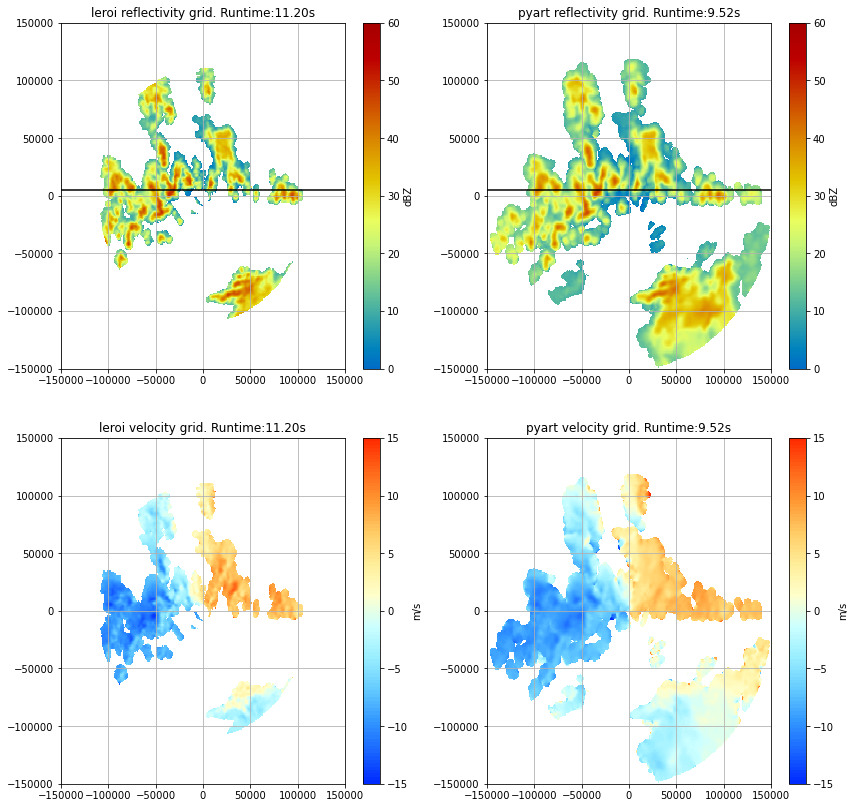

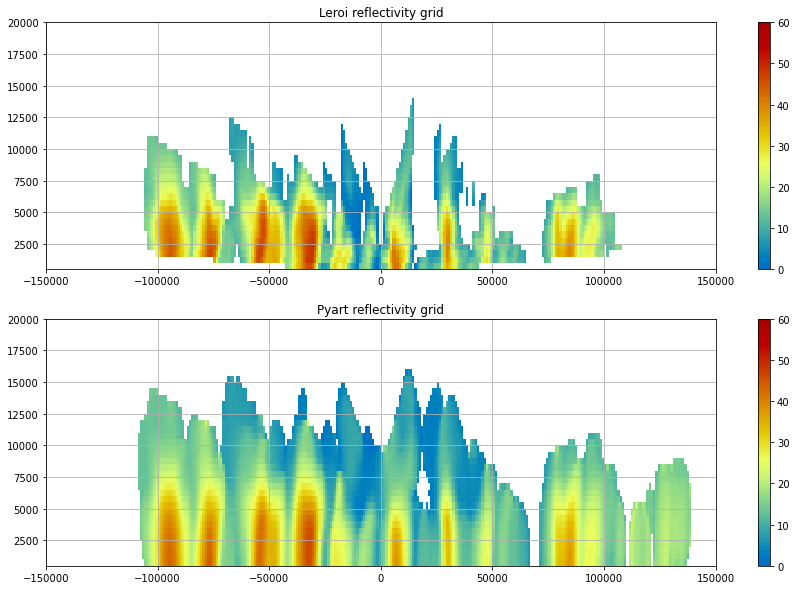

In [33]:
#Use a CPOL file to compare leroi with pyart gridding. The runtime of each process is printed in the plot title

date = '20140218'
dirr = '/g/data/hj10/cpol/cpol_level_1b/v2020/ppi/2014/{}/'.format(date)
file_list = os.listdir(dirr)

radar_ffn = f'{dirr}/{file_list[25]}'
run_test(radar_ffn, dbz_fname='corrected_reflectivity', vrad_name='corrected_velocity', 
         grid_fields=['corrected_reflectivity','corrected_velocity'], yidx=155, level=5)

Text(0.5, 1.0, 'Different (more-less) reflectivity grid')

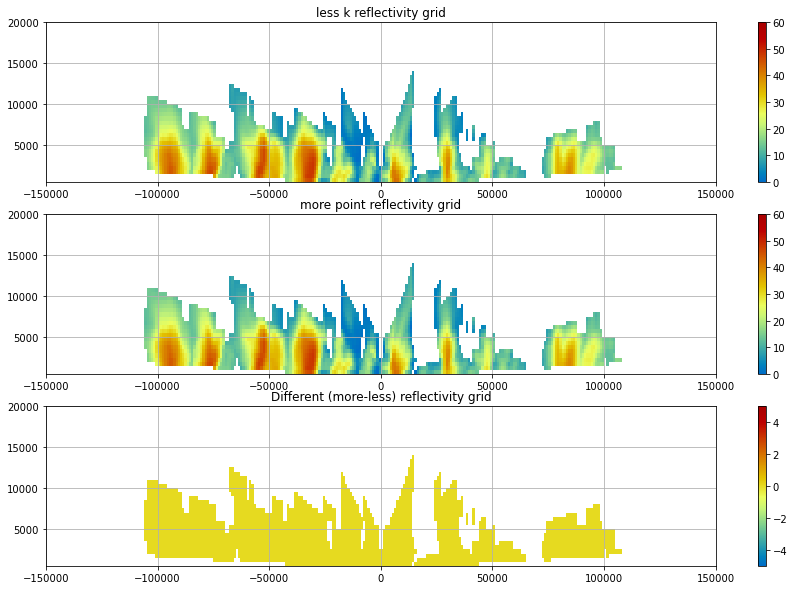

In [38]:
#compare impact of k (maximum number of neighbours) upon leroi gridding.

less_k = 5
more_k = 100

grid_less =  run_leroi_grid(radar_ffn, dbz_fname='corrected_reflectivity',
         grid_fields=['corrected_reflectivity','corrected_velocity'], Rc=3500, k=less_k)
grid_more =  run_leroi_grid(radar_ffn, dbz_fname='corrected_reflectivity',
         grid_fields=['corrected_reflectivity','corrected_velocity'], Rc=3500, k=more_k)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(311)
m = ax.pcolormesh(x,z,grid_less.fields['corrected_reflectivity']['data'][:,155,:], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 60)
plt.colorbar(m)
plt.grid()
ax.set_title('less k reflectivity grid')

ax = fig.add_subplot(312)
m = ax.pcolormesh(x,z,grid_more.fields['corrected_reflectivity']['data'][:,155,:], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 60)
plt.colorbar(m)
plt.grid()
ax.set_title('more point reflectivity grid')


ax = fig.add_subplot(313)
m = ax.pcolormesh(x,z,grid_more.fields['corrected_reflectivity']['data'][:,155,:]-grid_less.fields['corrected_reflectivity']['data'][:,155,:],
                  cmap ='pyart_HomeyerRainbow', vmin = -5, vmax = 5)
plt.colorbar(m)
plt.grid()
ax.set_title('Different (more-less) reflectivity grid')